In [1]:
# # https://blaylockbk.github.io/goes2go/_build/html/reference_guide/index.html#rgb-recipes
# from goes2go.data import goes_latest
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

In [2]:
# Download a GOES ABI dataset
# G = goes_latest(satellite='noaa-goes16', product='ABI-L2-MCMIP', domain='C', return_as='xarray', 
#                 download=True, overwrite=False, 
#                 s3_refresh=True, verbose=True)
# OR_ABI-L2-CMIPM1-M3C02_G16_s20171931811268_e20171931811326_c20171931811393.nc

In [3]:
# Read in Level 2 NetCDF
# ref_ch2 = G.variables['CMI'][:]
# g16nc.close()
# g16nc = None

In [4]:
# Download the utilities.py script, created by INPE (contains some useful functions for processing GOES-R data)
# !wget -c https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py

(<osgeo.gdal.GDALWarpAppOptions; proxy of <Swig Object of type 'GDALWarpAppOptions *' at 0x7f3cc9041f90> >, None, None)


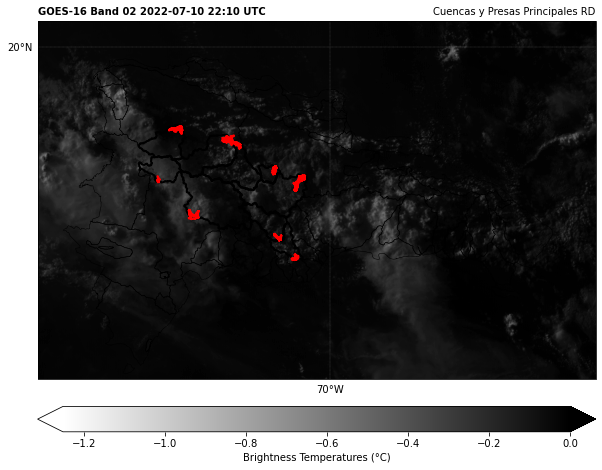

In [1]:
#-----------------------------------------------------------------------------------------------------------
# INPE / CPTEC - Training: Python and GOES-R Imagery: Script 14 - Reprojection with GDAL
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset                     # Read / Write NetCDF4 files
import matplotlib.pyplot as plt                 # Plotting library
from datetime import datetime                   # Basic Dates and time types
import cartopy, cartopy.crs as ccrs             # Plot maps
import os                                       # Miscellaneous operating system interfaces
from osgeo import osr                           # Python bindings for GDAL
from osgeo import gdal                          # Python bindings for GDAL
import numpy as np                              # Scientific computing with Python
from utilities import download_CMI              # Our function for download

import cartopy.io.shapereader as shpreader  # Import shapefiles

import geopandas

#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "./content/Samples"; os.makedirs(input, exist_ok=True)
output = "./content/Output"; os.makedirs(output, exist_ok=True)

# Desired extent
extent = [-140.0, 10.0, -60.0, 60.0] # Min lon, Min lat, Max lon, Max lat

# Datetime to process
yyyymmddhhmn = '202207102210'
band = '02'

# Download the file
file_name = download_CMI(yyyymmddhhmn, band, input)

#-----------------------------------------------------------------------------------------------------------
# Variable
var = 'CMI'

# Open the file
img = gdal.Open(f'NETCDF:{input}/{file_name}.nc:' + var)

# Read the header metadata
metadata = img.GetMetadata()
scale = float(metadata.get(var + '#scale_factor'))
offset = float(metadata.get(var + '#add_offset'))
undef = float(metadata.get(var + '#_FillValue'))
dtime = metadata.get('NC_GLOBAL#time_coverage_start')

# Load the data
ds = img.ReadAsArray(0, 0, img.RasterXSize, img.RasterYSize).astype(float)

# Apply the scale, offset and convert to celsius
# ds = (ds * scale + offset) - 273.15
ds = (ds * scale + offset) * (-1)

# Read the original file projection and configure the output projection
source_prj = osr.SpatialReference()
source_prj.ImportFromProj4(img.GetProjectionRef())

target_prj = osr.SpatialReference()
target_prj.ImportFromProj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

# Reproject the data
GeoT = img.GetGeoTransform()
driver = gdal.GetDriverByName('MEM')
raw = driver.Create('raw', ds.shape[0], ds.shape[1], 1, gdal.GDT_Float32)
raw.SetGeoTransform(GeoT)
raw.GetRasterBand(1).WriteArray(ds)

# Define the parameters of the output file  
options = gdal.WarpOptions(format = 'netCDF', 
          srcSRS = source_prj, 
          dstSRS = target_prj,
          outputBounds = (extent[0], extent[3], extent[2], extent[1]), 
          outputBoundsSRS = target_prj, 
          outputType = gdal.GDT_Float32, 
          srcNodata = undef, 
          dstNodata = 'nan', 
          xRes = 0.005, 
          yRes = 0.005, 
          resampleAlg = gdal.GRA_NearestNeighbour)

print(options)

# Write the reprojected file on disk
gdal.Warp(f'{output}/{file_name}_ret.nc', raw, options=options)
#-----------------------------------------------------------------------------------------------------------
# Open the reprojected GOES-R image
file = Dataset(f'{output}/{file_name}_ret.nc')

# Get the pixel values
data = file.variables['Band1'][:]
#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10))

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.PlateCarree())

# Define the image extent
img_extent = [extent[0], extent[2], extent[1], extent[3]]
ax.set_extent([-72.2, -68, 17.5, 20.2])

# Define the color scale based on the channel
colormap = "gray_r" # White to black for IR channels
    
# Plot the image
img = ax.imshow(data, origin='upper', extent=img_extent, cmap=colormap)


#--------------------------------------------------------------------------------------------------------------------------
# Add a shapefile
# shapefile = list(shpreader.Reader('/content/ne_10m_admin_1_states_provinces.shp').geometries())
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='gold',facecolor='none', linewidth=0.3)

map_crs = ccrs.PlateCarree()
data_crs= ccrs.PlateCarree()


cuencas_hidro_gdf              = geopandas.read_file('../shape_files/rd_shapes/vectores/Cuencas_Hidrograficas_RD.shp')
cuencas_presas_gdf             = geopandas.read_file('../shape_files/rd_shapes/vectores/Presas-CuencasAporte.shp')

cuencas_hidro_gdf              = cuencas_hidro_gdf.to_crs("EPSG:4326")
cuencas_presas_gdf             = cuencas_presas_gdf.to_crs("EPSG:4326")

ax.add_geometries(cuencas_hidro_gdf['geometry'], crs=data_crs, facecolor='none',
                  edgecolor='black', linewidth=0.5)

ax.add_geometries(cuencas_presas_gdf['geometry'][:9], crs=data_crs, facecolor='none',
                  edgecolor='black', linewidth=2)

ax.add_geometries(cuencas_presas_gdf['geometry'][9:], crs=data_crs, facecolor='none',
                  edgecolor='red', linewidth=2)

                  
# Add coastlines, borders and gridlines
# ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
# ax.add_geometries(shapefile, ccrs.PlateCarree(), edgecolor='white',facecolor='none', linewidth=1.0)
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='gray', alpha=1.0, linestyle='--', linewidth=0.25, xlocs=np.arange(-180, 180, 5), ylocs=np.arange(-90, 90, 5), draw_labels=True)
gl.top_labels = False
gl.right_labels = False                  

#--------------------------------------------------------------------------------------------------------------------------



# Add a colorbar
plt.colorbar(img, label='Brightness Temperatures (°C)', extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = (datetime.strptime(dtime, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band 02 ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Cuencas y Presas Principales RD', fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'output.png', bbox_inches='tight', pad_inches=0, dpi=300)

# Show the image
plt.show()

In [2]:
data

masked_array(
  data=[[-0.20761885, -0.222222  , -0.222222  , ..., -0.29714257,
         -0.31079334, -0.30920604],
        [-0.18730141, -0.18730141, -0.19904743, ..., -0.30507907,
         -0.29174575, -0.30126956],
        [-0.20285694, -0.20285694, -0.19396807, ..., -0.30984098,
         -0.30571398, -0.29714257],
        ...,
        [-0.05587296, -0.05365074, -0.05460312, ..., -0.02984124,
         -0.0349206 , -0.03238092],
        [-0.07365073, -0.08285706, -0.08126976, ..., -0.03047616,
         -0.02920632, -0.03047616],
        [-0.05999994, -0.05999994, -0.0539682 , ..., -0.03047616,
         -0.031746  , -0.0301587 ]],
  mask=False,
  fill_value=1e+20)